## FireNet YOLO custom data set training

In [2]:
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import distutils.dir_util
import yaml
import csv

## Set up for YOLO training

In [4]:
yolo_version = "yolov5"
if not os.path.exists(yolo_version):
    if yolo_version == "yolov5":
        !git clone https://github.com/ultralytics/yolov5.git
    if yolo_version == "yolov7":
        !git clone https://github.com/WongKinYiu/yolov7

In [3]:
pretrained_weights_file = "yolov5n6.pt"
if not os.path.exists(pretrained_weights_file): #TODO this is not working
    !curl https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt --output {pretrained_weights_file}

In [5]:
%pip install -r "$yolo_version"/requirements.txt
%pip install setuptools==59.5.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 1.22.0 Requires-Python >=3.8; 1.22.1 Requires-Python >=3.8; 1.22.2 Requires-Python >=3.8; 1.22.3 Requires-Python >=3.8; 1.22.4 Requires-Python >=3.8; 1.23.0 Requires-Python >=3.8; 1.23.0rc1 Requires-Python >=3.8; 1.23.0rc2 Requires-Python >=3.8; 1.23.0rc3 Requires-Python >=3.8; 1.23.1 Requires-Python >=3.8; 1.23.2 Requires-Python >=3.8; 1.23.3 Requires-Python >=3.8; 1.23.4 Requires-Python >=3.8; 1.23.5 Requires-Python >=3.8; 1.24.0 Requires-Python >=3.8; 1.24.0rc1 Requires-Python >=3.8; 1.24.0rc2 Requires-Python >=3.8; 1.24.1 Requires-Python >=3.8; 1.24.2 Requires-Python >=3.8; 1.24.3 Requires-Python >=3.8; 1.24.4 Requires-Python >=3.8; 1.25.0 Requires-Python >=3.9; 1.25.0rc1 Requires-Python >=3.9; 1.25.1 Requires-Python >=3.9; 1.25.2 Requires-Python >=3.9; 1.26.0b1 Requires-Python <3.13,>=3.9
ERROR: Could not find a version that satisfies the requirement numpy>=1.22.2 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.

Note: you may need to restart the kernel to use updated packages.


## Setup file paths 

In [6]:
src_path = os.getcwd()
base_path, _ = os.path.split(src_path)
data_filename = "FireNet.zip"
if 'google.colab' in str(get_ipython()):
  data_path = os.path.join(src_path,"data")
else:
  data_path = os.path.join(base_path,"data")

annotations_path = os.path.join(data_path,"FireNet_ObjectDetection")
images_path = os.path.join(data_path,"FireNet_Images")

## Donload and unzip data

In [ ]:
if not os.path.exists(data_path):
    os.makedirs(data_path)
    !wget --content-disposition -nc https://rdr.ucl.ac.uk/ndownloader/articles/9137798/versions/1 -O "$data_filename"
    !unzip "$data_filename"
    !unzip -q /content/FireNet_Images.zip  -d  "$images_path"
    !unzip -q /content/FireNet_ObjectDetection.zip -d  "$annotations_path"

## Convert the Annotations into the YOLO Format
Adapted from https://blog.paperspace.com/train-yolov5-custom-data/#convert-the-annotations-into-the-yolo-v5-format

In [7]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [8]:
labels_file = os.path.join(data_path, "FireNet_labels.csv")
with open(labels_file, mode='r') as in_file:
    reader = csv.reader(in_file)
    next(reader) # Skipping header 
    class_name_to_id_mapping = {rows[1]:(int(rows[0])-1) for rows in reader}
print(class_name_to_id_mapping)

{'Alarm_Activator': 0, 'Fire_Blanket': 1, 'Fire_Exit': 2, 'Fire_Extinguisher': 3, 'Fire_Suppression_Signage': 4, 'Flashing_Light_Orbs': 5, 'Sounders': 6, 'White_Domes': 7}


In [9]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolo(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
    
    # Name of the file which we have to save 
    save_file_name = os.path.join(annotations_path, info_dict["filename"].replace("jpg", "txt"))
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [10]:
# Get the annotations
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolo(info_dict)
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "txt"]

100%|██████████| 1452/1452 [00:19<00:00, 74.79it/s]


In [11]:
def plot_bounding_box(image, annotation_list,class_id_to_name_mapping):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)),outline ="green")
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[obj_cls],fill="green")
    
    plt.imshow(np.array(image))
    plt.show()


### Testing the annotations

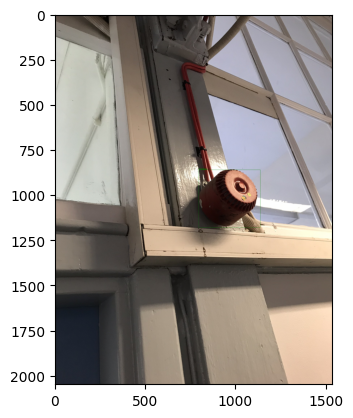

In [12]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]


#Get the corresponding image file
image_file = annotation_file.replace("FireNet_ObjectDetection", "FireNet_Images").replace("txt", "jpg")
assert os.path.exists(image_file)
#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list,class_id_to_name_mapping)

## Partition the Dataset

In [13]:
# Read images and annotations
images = [os.path.join(images_path, x) for x in os.listdir(images_path)]
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [14]:
#Utility function to copy images 
def copy_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

In [15]:
images_folder = os.path.relpath(os.path.join(data_path, "images"))
if os.path.exists(images_folder):
    shutil.rmtree(images_folder)
labels_folder = os.path.relpath(os.path.join(data_path, "labels"))
if os.path.exists(labels_folder):
    shutil.rmtree(labels_folder)

# Copy the splits into their folders

train_images_folder = os.path.join(images_folder, "train")
os.makedirs(train_images_folder, exist_ok=True)
copy_files_to_folder(train_images, train_images_folder)

val_images_folder = os.path.join(images_folder, "val")
os.makedirs(val_images_folder, exist_ok=True)
copy_files_to_folder(val_images, val_images_folder)

test_images_folder = os.path.join(images_folder, "test")
os.makedirs(test_images_folder, exist_ok=True)
copy_files_to_folder(test_images, test_images_folder)

train_labels_folder = os.path.join(labels_folder, "train")
os.makedirs(train_labels_folder, exist_ok=True)
copy_files_to_folder(train_annotations, train_labels_folder)

val_labels_folder = os.path.join(labels_folder, "val")
os.makedirs(val_labels_folder, exist_ok=True)
copy_files_to_folder(val_annotations, val_labels_folder)

test_labels_folder = os.path.join(labels_folder, "test")
os.makedirs(test_labels_folder, exist_ok=True)
copy_files_to_folder(test_annotations, test_labels_folder)

## Create and Copy Config File 

In [16]:
config_file_dict = {"train": train_images_folder, "val": val_images_folder, "test": test_images_folder , "nc":len(class_name_to_id_mapping), "names":list(class_name_to_id_mapping.keys())}
with open('Fire_Detector.yaml', 'w') as outfile:
  yaml_string=yaml.dump(config_file_dict, outfile)
shutil.copy("Fire_Detector.yaml", f"{yolo_version}/data") 

'yolov5/data\\Fire_Detector.yaml'

# Generate run output name

In [17]:
# Taken from https://stackoverflow.com/questions/57751402/increment-directory-name-if-it-already-exists
def generateDirectoryName(name, x=0):
    dir_name = (name + (str(x) if x is not 0 else '')).strip()
    if not os.path.exists(dir_name):
        return dir_name
    else:
        return generateDirectoryName(name, x + 1)
    
run_name = "yolo_fire_detector"
run_folder = os.path.join(src_path,"runs","train",run_name)
run_folder = generateDirectoryName(run_folder) # Checking if clash of existing folder name  
run_name = os.path.basename(os.path.normpath(run_folder)) # Updating run name if clash

## Train the Model

In [26]:
!python yolov5/train.py --img 640   --batch-size 2 --epochs 100  --data Fire_Detector.yaml --weights yolov5n6.pt --workers 1 --name "$run_name"  --device 0    

data Fire_Detector.yaml
s None


train: weights=yolov5n6.pt, cfg=, data=Fire_Detector.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=100, batch_size=2, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=1, project=yolov5\runs\train, name=yolo_fire_detector1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-210-gdd10481 Python-3.7.16 torch-1.10.1+cu113 CUDA:0 (NVIDIA GeForce GTX 970, 4096MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0,

## Copy Run Output and Save

In [19]:
run_dest_folder = os.path.join(data_path,"runs",yolo_version,run_name)
distutils.dir_util.copy_tree(run_folder, run_dest_folder)

DistutilsFileError: cannot copy tree 'c:\Users\jacob\code\Fire-Detector\src\runs\train\yolo_fire_detector1': not a directory